In [1]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

c:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
c:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

C:\Users\BIG3-09\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\BIG3-09\.cache\huggingface\hub\models--CompVis--stable-diffusion-v1-4. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [2]:
from diffusers import UniPCMultistepScheduler
scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")


scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [3]:
# 로컬 gpu가 좋지 못하므로 cpu에서 진행
torch_device = "cpu"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

In [4]:
#stable diffusion은 text embedding과 image embedding을 latent space에서 활용한다.
#따라서 text를 embedding해주는 것이 중요하다.
prompt = ['looks like very tired peoples on the train']
height = 512 # sd의 기본 높이
width = 512 # sd의 기본 너비 
num_inference_steps = 25 #노이즈 제거 step (반복)
guidance_scale = 7.5 # classifier-free guidance를 위한 scale
generator = torch.manual_seed(42) # 초기 노이즈를 생성하는 seed
batch_size = len(prompt)

In [5]:
text_input = tokenizer(prompt,padding="max_length",max_length=tokenizer.model_max_length,truncation=True, return_tensors='pt')

with torch.no_grad():
    text_embedding = text_encoder(text_input.input_ids.to(torch_device))[0]

In [7]:
# 이렇게 텍스트에 대한 임베딩을 출력하고 패딩 토큰의 임베딩도 생성해야한다. 
# 이 임베딩은 conditional text embedding과 동일한 shape를 가져야한다.
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
# 두번에 forward pass를 피하기 위해서 두 임베딩을 배치로 연결
text_embeddings = torch.cat([uncond_embeddings,text_embedding])

In [8]:
#random noise 생성
#diffusion은 random noise한 이미지로부터 원본의 이미지를 만들어내는 작업이 디폴트이다.
#따라서 diffusion 프로세스의 시작으로 초기 랜덤 노이즈를 생성한다.
#이것이 이미지의 잠재표현이고 위에서 설정한 step만큼 노이즈 제거 학습이 이루어진다.
latents = torch.randn(
    (batch_size,unet.in_channels,height//8,width//8), #vae모델에 3개의 다운샘플링 레이어가 있기 때문에 높이와 너비를 8로 나눠줌
    generator=generator,
    device=torch_device
)

#이미지 노이즈 제거
#스케줄러에 필요한 노이즈 스케일 값인 초기 노이즈 분포 sigma로 노이즈(입력)를 스케일링한다.
latents = latents*scheduler.init_noise_sigma

C:\Users\BIG3-09\AppData\Local\Temp\ipykernel_8844\4283609540.py:6: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size,unet.in_channels,height//8,width//8), #vae모델에 3개의 다운샘플링 레이어가 있기 때문에 높이와 너비를 8로 나눠줌


In [10]:
# 입력으로 들어가는 노이즈를 점진적으로 프롬프트에 설명된 이미지로 변환하는 노이즈 제거 작업을 진행한다.
# 노이즈 제거 루프는 세가지 작업을 수행해야한다.
# 1. 노이즈 제거 중 사용할 스케줄러의 timesteps를 설정한다.
# 2. timestep을 따라 반복한다.
# 3. time step에서 Unet을 호출해서 noise residual을 예측하고 스케줄러에 전달하여 이전 노이즈 샘플을 계산한다.

from tqdm.auto import tqdm
scheduler.set_timesteps(num_inference_steps) #timesteps를 설정한다.
for t in tqdm(scheduler.timesteps):
    # classifier-free guidance를 수행하는 경우 두번의 forward pass를 수행하지 않도록 latent를 확장한다.
    latent_mode_input = torch.cat([latents]*2)
    latent_mode_input = scheduler.scale_model_input(latent_mode_input,timestep=t)

    # noise residual 예측
    with torch.no_grad():
        noise_pred = unet(latent_mode_input,t,encoder_hidden_states = text_embeddings).sample #unet의 노이즈 예측 시 text embedding사용
    
    #guidance 수행
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #이전 노이즈 계산
    latents = scheduler.step(noise_pred,t,latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

In [11]:
# vae로 이미지 디코딩
latents = 1/0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample



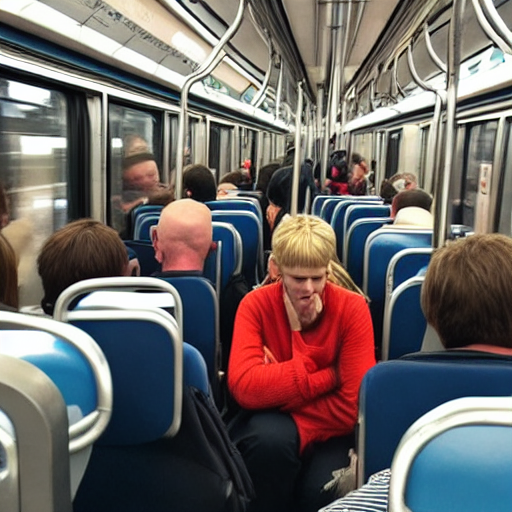

In [12]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [ ]:
# classifier-free guidance 란?
# 2021년에 NIPS에서 발표된 논문이고 noisy image로 학습한 classifier로부터 gradient를 사용해서 class guidance를 하는 기존의 방법은 classifier를 추가로 학습해야한다는 단점이 있었다. 
#classifier free guidance는 별도의 classifier 없이 할 수 있는 방법을 제안한다.
